# Problem 2 Model
A notebook containing the models for Problem 2. A credit risk analyst is using previous loan data to predict if a new loan from a new or existing customer will go default, calculate its recoveries if default and calculate an interest rate for the loan.

It includes two classification models, one predicting if the loan will be default ('default_ind'), and one for recoveries being zero or non-zero, one regression model predicting the value of the non-zero recoveries and one regression model predicting interest rate.

In [5]:
#Imports

#Data
import pandas as pd
import numpy as np

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#Other
import pickle

#ML

#General
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


#Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor

In [6]:
#Getting the csv file's name with the wrangled data
data_file='wrang_xyz_data.csv'

#Splitting the data into different categories that make sense
loan_data=['purpose','initial_list_status','term','loan_amnt']
emp_data=['emp_length','collections_12_mths_ex_med','acc_now_delinq','home_ownership','annual_inc','verification_status','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','total_acc','earliest_cr_line','dti','tot_cur_bal','tot_coll_amt'] #address
features=loan_data+emp_data
ohe_cols=['purpose','verification_status','home_ownership','initial_list_status','term'] #address
#The following inputs are left out as they are only useful for problem 1.
#out_old=['last_pymnt_d','last_credit_pull_d','recoveries','collection_recovery_fee','last_pymnt_amnt','total_pymnt','total_rec_int','int_rate','out_prncp',total_rec_late_fee','default_ind','total_rev_hi_lim','revol_util','revol_bal']

In [7]:
def one_hot_encode(x_train,x_test,ohe_cols=ohe_cols,pickled='no',ohe_name=''):
        ohe = OneHotEncoder(handle_unknown='ignore')
        ohe.fit(x_train[ohe_cols])

        if pickled=='yes':
                pickle.dump(ohe,open(ohe_name,'wb'))
        else:
                pass
                
        x_train_enc = pd.DataFrame(ohe.transform(x_train[ohe_cols]).toarray(),index=x_train.index)
        x_train=x_train.join(x_train_enc).drop(ohe_cols,axis=1)
        x_train.columns = x_train.columns.map(str)

        x_test_enc = pd.DataFrame(ohe.transform(x_test[ohe_cols]).toarray(),index=x_test.index)
        x_test=x_test.join(x_test_enc).drop(ohe_cols,axis=1)
        x_test.columns = x_test.columns.map(str)

        return x_train,x_test

[[  2283   9313]
 [  9636 192756]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    202392
           1       0.19      0.20      0.19     11596

    accuracy                           0.91    213988
   macro avg       0.57      0.57      0.57    213988
weighted avg       0.91      0.91      0.91    213988

no defaults: roc auc = 0.500
model prediction: roc auc = 0.718


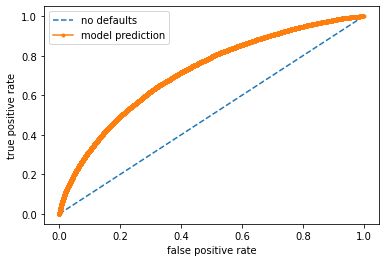

In [9]:
#Classification model predicting default_ind for problem 2
#The model's inputs are the data_file which should be set equal to the wrangled data file, the way to train test split
#date does it according to  date, otherwise it is random, the algorithm used for the model and if hyperparameter tuning
#investigation should be run on the model.

def get_model_class(data_file='wrang_xyz_data.csv',split='date',model_type='xgb',hyper_tune='no',sampling='no'):
    #Imporitng the wrangled csv file and including the useful columns for it
    pred_data=['issue_d','default_ind']
    df = pd.read_csv('data/'+data_file,usecols=features+pred_data)

    

    #Selecting train test split method to be random
    if split=='random':
        #Creating X and y variables for input and output
        X=df.drop(['default_ind','issue_d'],axis=1)
        y=df['default_ind']
        
        if sampling=='yes':


        #Undersampling the data to create a more balanced dataset
            undersample = RandomUnderSampler(sampling_strategy='majority')
            X,y = undersample.fit_resample(X, y)
            
            #Splitting the data into train and test
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)
            scale_pos_ratio=1
        else:

            #Splitting the data into train and test
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

            scale_pos_ratio=len(y_train[y_train==0])/len(y_train[y_train==1])
            sqrt_scale_pos_ratio=np.sqrt(scale_pos_ratio)
            scale_pos_ratio=(0.15*scale_pos_ratio+0.85*sqrt_scale_pos_ratio)

        #One-hot Encoding
        X_train,X_test=one_hot_encode(X_train,X_test,pickled='no',ohe_name='ohe_class_def')
    #Selecting train test split method to be done based on date
    else:
        #Creating X and y variables for input and output
        X=df.drop('default_ind',axis=1)
        y=df[['default_ind','issue_d']]

        #Splitting the dataset according to date
        X_train=X[X['issue_d']<=20150501].drop('issue_d',axis=1)
        X_test=X[X['issue_d']>20150501].drop('issue_d',axis=1)

        y_train=y[y['issue_d']<=20150501]['default_ind']
        y_test=y[y['issue_d']>20150501]['default_ind']

        #Undersampling the data to create a more balanced dataset
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_train,y_train = undersample.fit_resample(X_train, y_train)
        X_test,y_test = undersample.fit_resample(X_test, y_test)

        #One-hot Encoding
        X_train,X_test=one_hot_encode(X_train,X_test,pickled='no',ohe_name='ohe_class_def')


    #Selecting xgboost algorithm
    if model_type=='xgb':

        #Selecting random hyperparameter tuning investigation
        if hyper_tune=='random':
            
            #Establishing Parameters
            params = { 'max_depth': [3, 5, 6, 10, 15, 20],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': np.arange(0.5, 1.0, 0.1),
            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
            'n_estimators': [100, 500, 1000]}

            #Running xgboost model for different parameter combinations based on accuracy
            model_class = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss')

            model_class = RandomizedSearchCV(estimator=model_class,
                            param_distributions=params,
                            scoring='accuracy',
                            n_iter=25,
                            verbose=1)
            model_class.fit(X_train,np.ravel(y_train))

            #Printing best parameters and accuracy
            print("Best parameters:", model_class.best_params_)
            print("Highest Accuracy: ", (model_class.best_score_))

        #Runs the model normally
        else:

            model_class = xgb.XGBClassifier(scale_pos_weight=scale_pos_ratio) #use_label_encoder=False,eval_metric='logloss',subsample= 0.7999999999999999, n_estimators= 500, max_depth= 15, learning_rate= 0.01, colsample_bytree= 0.5, colsample_bylevel= 0.4
            model_class.fit(X_train,np.ravel(y_train))

           #Plotting feature importance         
            #fig, ax = plt.subplots(figsize=(10,10))
            #xgb.plot_importance(model_class,importance_type='weight', ax=ax)

    #Selecting logistic regression model
    elif model_type=='lg_reg':
        model_class=LogisticRegression(max_iter=10*6)
        model_class.fit(X_train,np.ravel(y_train))

    #Selecting random forest model
    else: 
        model_class = RandomForestClassifier()
        model_class.fit(X_train,np.ravel(y_train))

    #Predicting values and printing confusion matrix and classification report
    y_class_pred = model_class.predict(X_test)
    print(confusion_matrix(y_test, y_class_pred,labels=[1,0]))
    print(classification_report(y_test, y_class_pred))

    prob_default = model_class.predict_proba(X_test)[:,1]
    false_auc = roc_auc_score(y_test, y_test.clip(upper = False))
    model_auc = roc_auc_score(y_test, prob_default)

    print('no defaults: roc auc = %.3f' % (false_auc))
    print('model prediction: roc auc = %.3f' % (model_auc))


    false_fpr, false_tpr, _ = roc_curve(y_test, y_test.clip(upper = False))
    model_fpr, model_tpr, _ = roc_curve(y_test, prob_default)

    plt.plot(false_fpr, false_tpr, linestyle = '--', label = 'no defaults')
    plt.plot(model_fpr, model_tpr, marker = '.', label = 'model prediction')

    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend()
    plt.show()

    return model_class

#Running the function
model_class=get_model_class(split='random',model_type='xgb',hyper_tune='no',sampling='no')

#Dumping the model to be used for the app.py file. Comment out only if intending to run app.py
#pickle.dump(model_class,open('model_class_def','wb'))

In [21]:
#Classification model predicting zero or non-zero recoveries for problem 2
#The model's inputs are the data_file which should be set equal to the wrangled data file
#the algorithm used for the model and if hyperparameter tuning
#investigation should be run on the model.

def get_model_class(data_file='wrang_xyz_data.csv',model_type='xgb',hyper_tune='no',sampling='no'):
    #Imporitng the wrangled csv file and including the useful columns for it
    pred_data=['default_ind','recoveries','collection_recovery_fee']
    df = pd.read_csv('data/'+data_file,usecols=features+pred_data)
    #Getting only the cases that the loan is default
    df=df[df['default_ind']==1].drop('default_ind',axis=1)

    #Combining recoveries and recovery fees
    df['recoveries']=df['recoveries']+df['collection_recovery_fee']

    #Substituting all non-zero recoveries to 1
    df['recoveries']=df['recoveries'].where(df['recoveries']==0,1)
    df=df.drop('collection_recovery_fee',axis=1)

    #Creating X and y variables for input and output
    X=df.drop('recoveries',axis=1)
    y=df['recoveries']

    if sampling=='yes':
    #Undersampling the data to create a more balanced dataset
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X,y = undersample.fit_resample(X, y)
        
        #Splitting the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)
        scale_pos_ratio=1

    else:
        #Splitting the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

        scale_pos_ratio=len(y_train[y_train==0])/len(y_train[y_train==1])
        #print(scale_pos_ratio)
        sqrt_scale_pos_ratio=np.sqrt(scale_pos_ratio)
        scale_pos_ratio=(0.15*scale_pos_ratio+0.85*sqrt_scale_pos_ratio)

    #One-hot Encoding
    X_train,X_test=one_hot_encode(X_train,X_test,pickled='no',ohe_name='ohe_class_rec')

    #Selecting xgboost algorithm
    if model_type=='xgb':
        
        #Selecting random hyperparameter tuning investigation
        if hyper_tune=='random':
            
            #Establishing Parameters
            params = { 'max_depth': [3, 5, 6, 10, 15, 20],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': np.arange(0.5, 1.0, 0.1),
            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
            'n_estimators': [100, 500, 1000]}
            
            #Running xgboost model for different parameter combinations based on accuracy
            model_class = xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss')

            model_class = RandomizedSearchCV(estimator=model_class,
                            param_distributions=params,
                            scoring='accuracy',
                            n_iter=25,
                            verbose=1)
            model_class.fit(X_train,np.ravel(y_train))

            #Printing best parameters and accuracy
            print("Best parameters:", model_class.best_params_)
            print("Highest Accuracy: ", (model_class.best_score_))

        #Runs the model normally
        else:
            model_class = xgb.XGBClassifier(scale_pos_weight=scale_pos_ratio) #use_label_encoder=False,eval_metric='logloss',subsample= 0.6, n_estimators= 500, max_depth= 5, learning_rate= 0.01, colsample_bytree= 0.7, colsample_bylevel= 0.7999999999999999
            model_class.fit(X_train,np.ravel(y_train))

            #Plotting feature importance 
            #fig, ax = plt.subplots(figsize=(10,10))
            #xgb.plot_importance(model_class,importance_type='weight', ax=ax)

    #Selecting logistic regression algorithm
    elif model_type=='lg_reg':
        model_class=LogisticRegression(max_iter=10*6)
        model_class.fit(X_train,np.ravel(y_train))

    #Selecting random forest algorithm
    else: 
        model_class = RandomForestClassifier()
        model_class.fit(X_train,np.ravel(y_train))

    #Predicting values and printing confusion matrix and classification report
    y_class_pred = model_class.predict(X_test)
    print(confusion_matrix(y_test, y_class_pred))
    print(classification_report(y_test, y_class_pred))

    return model_class
    
#Running the function
model_class=get_model_class(model_type='xgb',hyper_tune='no',sampling='no')

#Dumping the model to be used for the app.py file. Comment out only if intending to run app.py
#pickle.dump(model_class,open('model_class_rec','wb'))

[[3334 2267]
 [2017 3999]]
              precision    recall  f1-score   support

         0.0       0.62      0.60      0.61      5601
         1.0       0.64      0.66      0.65      6016

    accuracy                           0.63     11617
   macro avg       0.63      0.63      0.63     11617
weighted avg       0.63      0.63      0.63     11617



In [22]:
#Regression model predicting recoveries for problem 2
#The model's inputs are the data_file which should be set equal to the wrangled data file,
#the algorithm used for the model, the value to be predicted and if hyperparameter tuning
#investigation should be run on the model.

def get_model_reg(data_file='wrang_xyz_data.csv',model_type='xgb',pred_value=['recoveries'],hyper_tune='no'):
    #Imporitng the wrangled csv file and including the useful columns for it
    pred_data=['collection_recovery_fee']
    df = pd.read_csv('data/'+data_file,usecols=features+pred_data+pred_value) 

    #Combining recoveries and recovery fees
    df['recoveries']=df['recoveries']+df['collection_recovery_fee']

    #Getting only non-zero recoveries
    df=df[df['recoveries']!=0].drop('collection_recovery_fee',axis=1)

    #Creating X and y variables for input and output
    X=df.drop(pred_value[0],axis=1)
    y=df[pred_value[0]]

    #Splitting the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

    #One-hot Encoding
    X_train,X_test=one_hot_encode(X_train,X_test,pickled='no',ohe_name='ohe_reg_rec')
   
    #Selecting xgboost algorithm
    if model_type=='xgb':

        #Selecting random hyperparameter tuning investigation
        if hyper_tune=='random':

            #Establishing Parameters
            params = { 'max_depth': [3, 5, 6, 10, 15, 20],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': np.arange(0.5, 1.0, 0.1),
            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
            'n_estimators': [100, 500, 1000]}

            #Running xgboost model for different parameter combinations based on r-sqaured
            model_reg = xgb.XGBRegressor() 

            model_reg = RandomizedSearchCV(estimator=model_reg,
                            param_distributions=params,
                            scoring='r2',
                            n_iter=25,
                            verbose=1)
            model_reg.fit(X_train,np.ravel(y_train))
            print("Best parameters:", model_reg.best_params_)
            print("Highest R2: ", (model_reg.best_score_))

        #Selecting grid hyperparameter tuning investigation
        elif hyper_tune=='grid':

            #Establishing Parameters
            params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

           #Running xgboost model for different parameter combinations based on negative mean squared error
            model_reg = xgb.XGBRegressor() 
            model_reg = GridSearchCV(estimator=model_reg, 
                            param_grid=params,
                            scoring='neg_mean_squared_error', 
                            verbose=1)


            model_reg = xgb.XGBRegressor()
            model_reg.fit(X_train,np.ravel(y_train))

            #Printing best parameters and r2
            print("Best parameters:", model_reg.best_params_)
            print("Lowest RMSE: ", (-model_reg.best_score_)**(1/2.0))

        
        #Runs the model normally
        else:
            model_reg = xgb.XGBRegressor(max_depth=5,learning_rate=0.01,colsample_bytree=0.6,n_estimators=500,subsample= 0.8999999999999999,colsample_bylevel=0.4) #max_depth=3,learning_rate=0.01,colsample_bytree=0.7,n_estimators=100
            model_reg.fit(X_train,np.ravel(y_train))

    #Selecting linear regression algorithm
    elif model_type=='lin_reg':
        model_reg=LinearRegression()
        model_reg.fit(X_train,np.ravel(y_train))

    #Selecting knn regression algorithm
    elif model_type=='knn':
        model_reg=KNeighborsRegressor(n_neighbors=1)
        model_reg.fit(X_train,np.ravel(y_train))

    #Selecting random forest regression algorithm
    elif model_type=='ran_for': 
        model_reg = RandomForestRegressor(n_estimators=200)
        model_reg.fit(X_train,np.ravel(y_train))
    
    #Selecting Deep Learning regression algorith
    else:
        model_reg = MLPRegressor().fit(X_train, y_train)
        model_reg.fit(X_train,y_train)

    #Predicting values
    y_reg_pred = model_reg.predict(X_test)

    #Getting error metrics
    mse = metrics.mean_squared_error(y_test, y_reg_pred)
    rmse = np.sqrt(mse)  
    r2 = metrics.r2_score(y_test,y_reg_pred)

    #Creating a custom error field. 
    error = np.mean(abs(y_test - y_reg_pred)/y_reg_pred)*100

    #Printing error metrics
    print("RMSE:", rmse)
    print("R-Squared:", r2)
    print(error)

    return model_reg

#Running the function    
model_reg=get_model_reg(model_type='xgb',pred_value=['recoveries'],hyper_tune='no')

#Dumping the model to be used for the app.py file. Comment out only if intending to run app.py
#pickle.dump(model_reg,open('model_reg_rec','wb'))

RMSE: 1651.4310979012246
R-Squared: 0.37405769296046554
50.96544920403115


In [23]:
#Regression model predicting intrest rate for problem 2
#The model's inputs are the data_file which should be set equal to the wrangled data file,
#the algorithm used for the model, the value to be predicted and if hyperparameter tuning
#investigation should be run on the model.
def get_model_reg(data_file='wrang_xyz_data.csv',model_type='xgb',pred_value=['int_rate'],hyper_tune='no'):
    #Imporitng the wrangled csv file and including the useful columns for it
    df = pd.read_csv('data/'+data_file,usecols=features+pred_value) 

    #Creating X and y variables for input and output
    X=df.drop([pred_value[0]],axis=1)
    y=df[pred_value[0]]

    #Splitting the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)

    #One-hot Encoding
    X_train,X_test=one_hot_encode(X_train,X_test,pickled='no',ohe_name='ohe_reg_int')

   
    #Selecting xgboost algorithm
    if model_type=='xgb':

        #Selecting random hyperparameter tuning investigation
        if hyper_tune=='random':

            #Establishing Parameters
            params = { 'max_depth': [3, 5, 6, 10, 15, 20],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'subsample': np.arange(0.5, 1.0, 0.1),
            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
            'n_estimators': [100, 500, 1000]}

            #Running xgboost model for different parameter combinations based on r-sqaured
            model_reg = xgb.XGBRegressor() #seed=20

            model_reg = RandomizedSearchCV(estimator=model_reg,
                            param_distributions=params,
                            scoring='r2',
                            n_iter=25,
                            verbose=1)
            model_reg.fit(X_train,np.ravel(y_train))

            #Printing best parameters and r2
            print("Best parameters:", model_reg.best_params_)
            print("Lowest R2: ", (model_reg.best_score_))

        #Selecting grid hyperparameter tuning investigation
        elif hyper_tune=='grid':

            #Establishing Parameters
            params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

           #Running xgboost model for different parameter combinations based on negative mean squared error
            model_reg = xgb.XGBRegressor()
            model_reg = GridSearchCV(estimator=model_reg, 
                            param_grid=params,
                            scoring='neg_mean_squared_error', 
                            verbose=1)
                    
            model_reg.fit(X_train,np.ravel(y_train))

            #Printing best parameters and negative mean squared error
            print("Best parameters:", model_reg.best_params_)
            print("Lowest RMSE: ", (-model_reg.best_score_)**(1/2.0))

        #Runs the model normall
        else:
            model_reg = xgb.XGBRegressor() #max_depth=3,learning_rate=0.01,colsample_bytree=0.7,n_estimators=100
            model_reg.fit(X_train,np.ravel(y_train))

    #Selecting linear regression algorithm
    elif model_type=='lin_reg':
        model_reg=LinearRegression()
        model_reg.fit(X_train,np.ravel(y_train))

    #Selecting knn regression algorithm
    elif model_type=='knn':
        model_reg=KNeighborsRegressor(n_neighbors=1)
        model_reg.fit(X_train,np.ravel(y_train))

    #Selecting random forest regression algorithm
    elif model_type=='ran_for': 
        model_reg = RandomForestRegressor(n_estimators=200)
        model_reg.fit(X_train,np.ravel(y_train))
    
    #Selecting Deep Learning regression algorith
    else:
        model_reg = MLPRegressor().fit(X_train, y_train)
        model_reg.fit(X_train,y_train)

    #Predicting values
    y_reg_pred = model_reg.predict(X_test)

    #Getting error metrics
    mse = metrics.mean_squared_error(y_test, y_reg_pred)
    rmse = np.sqrt(mse) 
    r2 = metrics.r2_score(y_test,y_reg_pred)

    #Creating a custom error field
    error = np.mean(abs(y_test - y_reg_pred)/y_reg_pred)*100

    #Printing error metrics
    print("RMSE:", rmse)
    print("R-Squared:", r2)
    print(error)

    return model_reg

#Running the function     
model_reg=get_model_reg(model_type='xgb',pred_value=['int_rate'],hyper_tune='no')

#Dumping the model to be used for the app.py file. Comment out only if intending to run app.py
#pickle.dump(model_reg,open('model_reg_int','wb'))

RMSE: 3.1474836644615722
R-Squared: 0.4814347771275608
19.620463468504564
